# GR00T Inference

This tutorial shows how to use the GR00T inference model to predict the actions from the observations, given a test dataset

In [1]:
import os
import torch
import gr00t
import numpy as np
from gr00t.data.dataset import LeRobotSingleDataset
from gr00t.model.policy import Gr00tPolicy

import matplotlib.pyplot as plt

/mloscratch/users/kalajdzi/anaconda3/envs/gr00t/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/mloscratch/users/kalajdzi/anaconda3/envs/gr00t/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/mloscratch/users/kalajdzi/anaconda3/envs/gr00t/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mloscratch/users/kalajd

In [2]:
# change the following paths
MODEL_PATH = "DavidKalajdzic/dr00ne-gr00t-lora-rank0" # some model that we trained on our dataset format (see finetune notebook)

DATASET_PATH = "/mloscratch/users/kalajdzi/track-hawk/data_track_hawk/dataset_drone_control"
EMBODIMENT_TAG = "new_embodiment"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading the model
The policy model is loaded from our checkpoint.
There are 2 new concepts here in the GR00T model:
 - modality config: This defines the keys in the dictionary used by the model. (e.g. `action`, `state`, `annotation`, `video`)
 - modality_transform: A sequence of transform which are used during dataloading

In [3]:
from gr00t.experiment.data_config import DATA_CONFIG_MAP

data_config =  DATA_CONFIG_MAP["track_hawk"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()

policy = Gr00tPolicy(
    model_path=MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

# print out the policy model architecture
print(policy.model)

2025-06-01 00:18:31.780531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-01 00:18:31.780585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-01 00:18:31.782252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 00:18:31.790028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Fetching 86 files: 100%|███████| 86/86 [00:00<00:00, 

Loading pretrained dual brain from /home/runai-home/.cache/huggingface/hub/models--DavidKalajdzic--dr00ne-gr00t-lora-rank0/snapshots/de958b89de7decef9f619433fe80ef2069c0bf57
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/runai-home/.cache/huggingface/hub/models--DavidKalajdzic--dr00ne-gr00t-lora-rank0/snapshots/de958b89de7decef9f619433fe80ef2069c0bf57


/mloscratch/users/kalajdzi/track-hawk/Isaac-GR00T/gr00t/model/action_head/cross_attention_dit.py:249: FutureWarning: Accessing config attribute `output_dim` directly via 'DiT' object attribute is deprecated. Please access 'output_dim' over 'DiT's config object instead, e.g. 'unet.config.output_dim'.
  self.proj_out_2 = nn.Linear(self.inner_dim, self.output_dim)


Total number of DiT parameters:  537803776


Some weights of the model checkpoint at /mloscratch/users/kalajdzi/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
GR00T_N1(
  (backbone): EagleBackbone(
    (model): Eagle2ChatModel(
      (vision_model): SiglipVisionModel(
        (vision_model): SiglipVisionTransformer(
          (embeddings): SiglipVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
            (position_embedding): Embedding(256, 1152)
          )
          (encoder): SiglipEncoder(
            (layers): ModuleList(
              (0-26): 27 x SiglipEncoderLayer(
                (self_attn): SiglipFlashAttention2(
                  (k_proj): lora.Linear(
                    (base_layer): Linear(in_features=1152, out_features=1152, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
       

## Loading dataset

In [4]:
dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,
    embodiment_tag=EMBODIMENT_TAG,
)

Initialized dataset dataset_drone_control with new_embodiment


As we defined in the episodes.jsonl we can see the number of frames of each episode:
```text
{"episode_index": 0, "tasks": ["look at the box and follow it"], "length": 906}
{"episode_index": 1, "tasks": ["look at the human and follow it"], "length": 1013}
{"episode_index": 2, "tasks": ["look at the dog and follow it"], "length": 906}
{"episode_index": 3, "tasks": ["look at the chicken and follow it"], "length": 906}
{"episode_index": 4, "tasks": ["look at the buffalo and follow it"], "length": 1048}
{"episode_index": 5, "tasks": ["look at the turtle and follow it"], "length": 906}


Let's print out a single data point and visualize it

In [5]:
import numpy as np
FRAME_INDEX = 100 # we have 6 episodes and in total they form 5685 total frames
step_data = dataset[FRAME_INDEX]

print(step_data)

{'video.rgb': array([[[[168, 173, 210],
         [167, 172, 209],
         [166, 171, 206],
         ...,
         [ 47,  46,  51],
         [ 64,  64,  90],
         [ 76,  76, 102]],

        [[168, 173, 210],
         [167, 172, 209],
         [166, 171, 206],
         ...,
         [ 39,  38,  43],
         [ 56,  56,  82],
         [ 68,  68,  94]],

        [[168, 173, 210],
         [168, 173, 210],
         [167, 172, 207],
         ...,
         [ 38,  35,  39],
         [ 63,  62,  77],
         [ 79,  78,  93]],

        ...,

        [[110, 117,  58],
         [112, 119,  60],
         [115, 121,  51],
         ...,
         [ 53,  52,  41],
         [ 40,  39,  28],
         [ 23,  22,  11]],

        [[111, 127,  54],
         [107, 123,  50],
         [110, 119,  48],
         ...,
         [ 52,  53,  43],
         [ 39,  40,  28],
         [ 22,  23,  11]],

        [[ 99, 115,  42],
         [100, 116,  43],
         [112, 121,  50],
         ...,
         [ 53,  54, 

In [6]:
for key, value in step_data.items():
    if isinstance(value, np.ndarray):
        print(key, value.shape)
    else:
        print(key, value)


video.rgb (1, 144, 256, 3)
video.depth (1, 144, 256, 3)
video.segmentation (1, 144, 256, 3)
state.drone_state (1, 9)
action.drone_action (16, 4)
annotation.human.action.task_description ['look at the box and follow it']


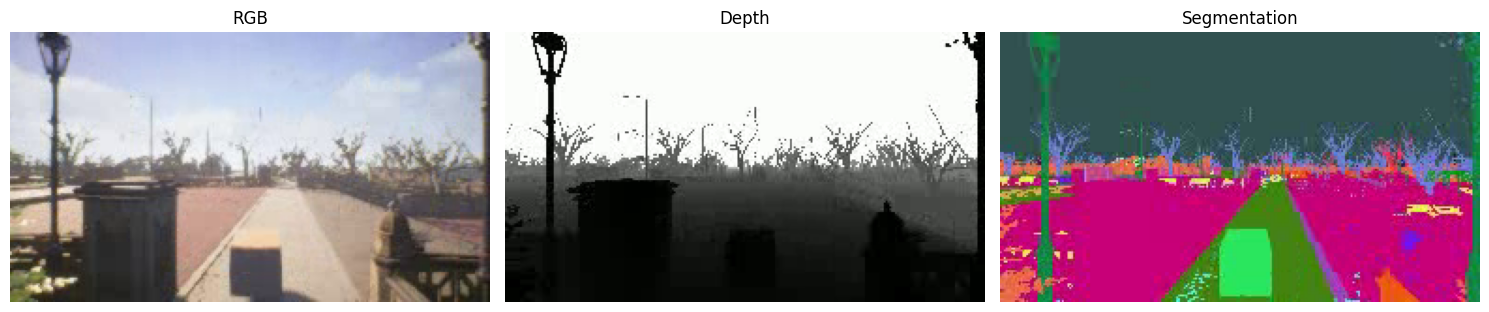

In [7]:
def display_step(step_data):
    # grab frames
    rgb = step_data['video.rgb'][0]
    depth = step_data['video.depth'][0]
    seg  = step_data['video.segmentation'][0]

    # prepare images
    rgb_img   = rgb.astype('uint8') if rgb.dtype != np.uint8 else rgb
    depth_img = depth    # if float [0–1], you can plt.imshow(depth_img, cmap='gray')
    seg_img   = seg.astype('uint8') if seg.dtype != np.uint8 else seg

    # plot side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax, im, title in zip(axs, [rgb_img, depth_img, seg_img], ['RGB', 'Depth', 'Segmentation']):
        ax.imshow(im, cmap='gray' if title=='Depth' else None)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_step(step_data)

Now let's visualize the state and action values over time

In [8]:
def display_state_and_action_data_across_time(episode_id):
    max_steps = 906
    sample_images = 10
    
    state_across_time = []
    action_across_time = []
    
    for step in range(max_steps):
        dp = dataset.get_step_data(episode_id, step)
        # extract drone state (9 dims) and action (4 dims)
        state = dp["state.drone_state"][0] # shape (9,)
        
        action = dp["action.drone_action"][0] # shape (4,)
        
        state_across_time.append(state)
        action_across_time.append(action)
        
    state_across_time = np.array(state_across_time)   # (max_steps, 9)
    action_across_time = np.array(action_across_time) # (max_steps, 4)

    
    print("plot state dims")
    fig, axs = plt.subplots(nrows=9, figsize=(8, 2*9))
    for i, ax in enumerate(axs):
        ax.plot(state_across_time[:, i], label=f"state dim {i}")
        ax.set_ylabel(f"d{i}")
        ax.legend()
    plt.tight_layout()
    plt.show()

    
    print("plot action dims")
    fig, axs = plt.subplots(nrows=4, figsize=(8, 2*4))
    for i, ax in enumerate(axs):
        ax.plot(action_across_time[:, i], label=f"action dim {i}")
        ax.set_ylabel(f"a{i}")
        ax.legend()
    plt.tight_layout()
    plt.show()

plot state dims


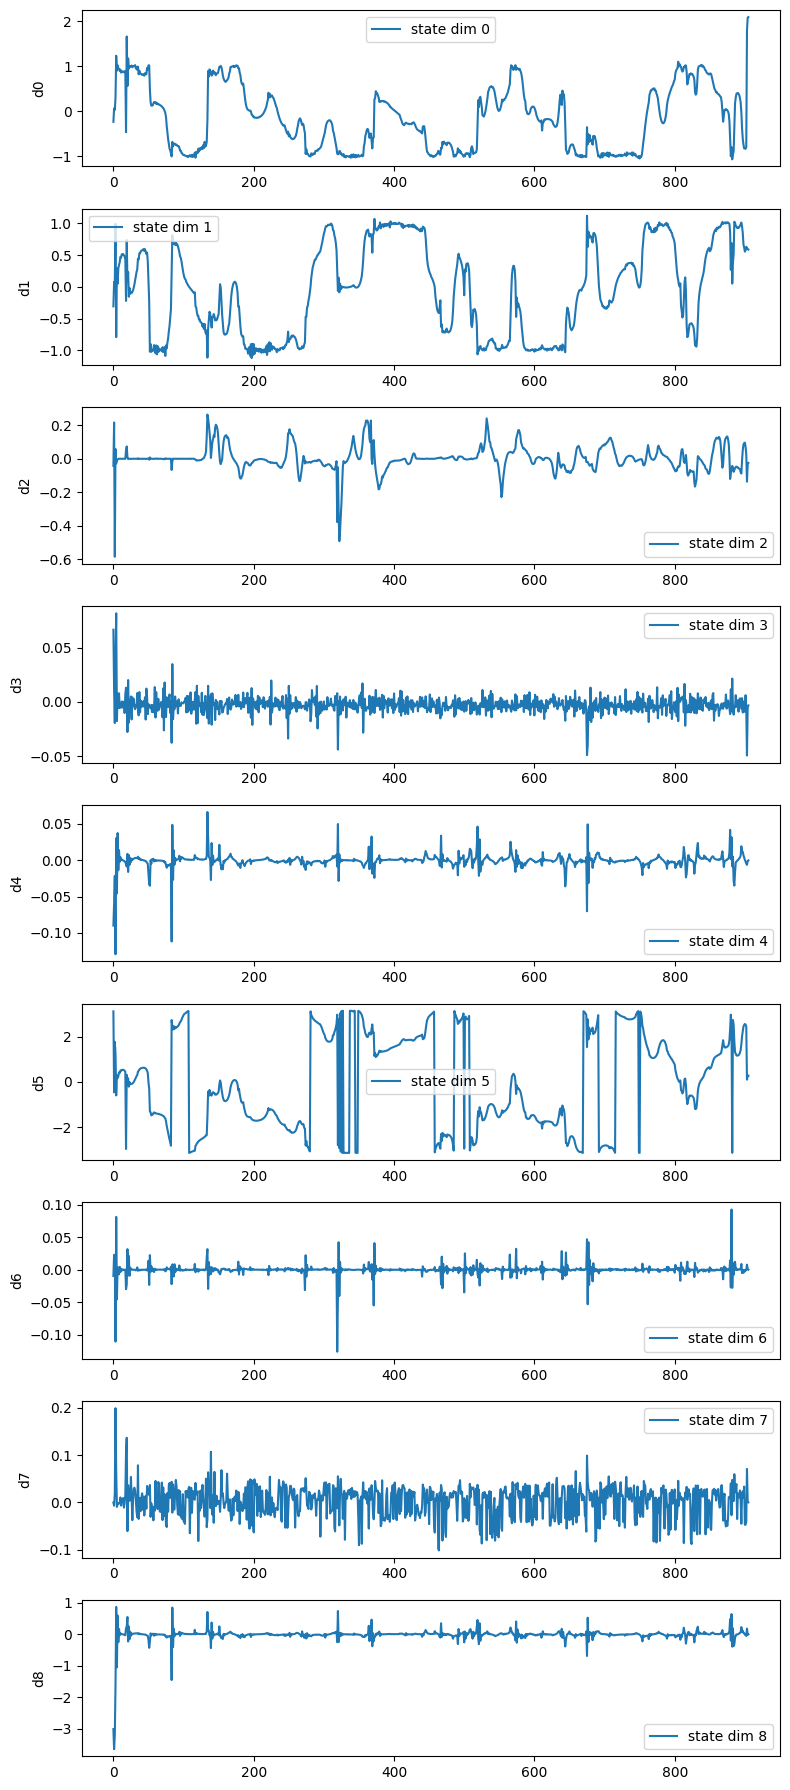

plot action dims


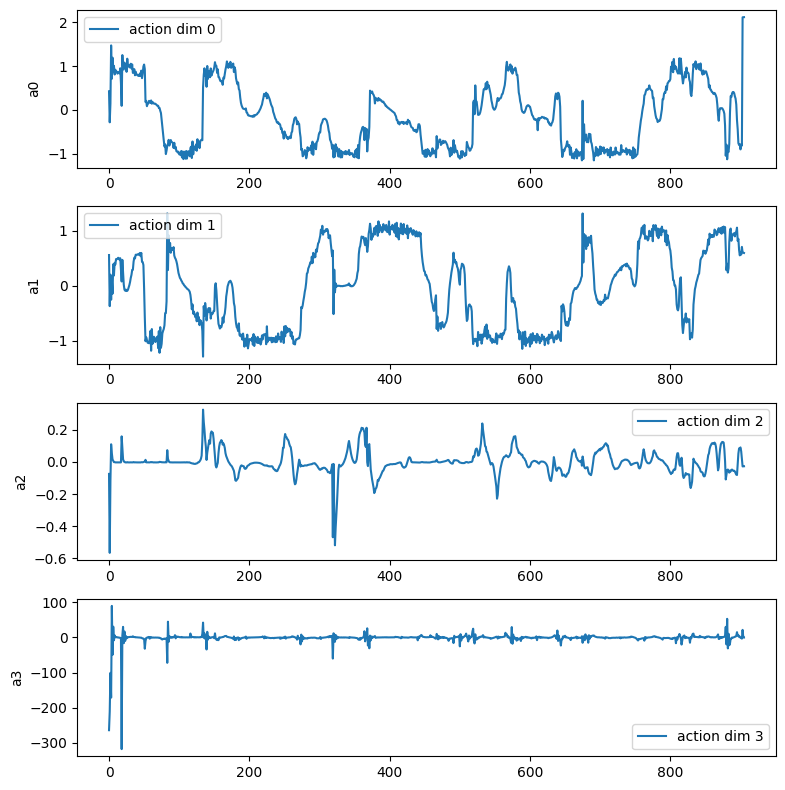

In [9]:
# let's compare the data of first and second episodes => notice how similar they are because we used the same path for the two objects...
display_state_and_action_data_across_time(0)

plot state dims


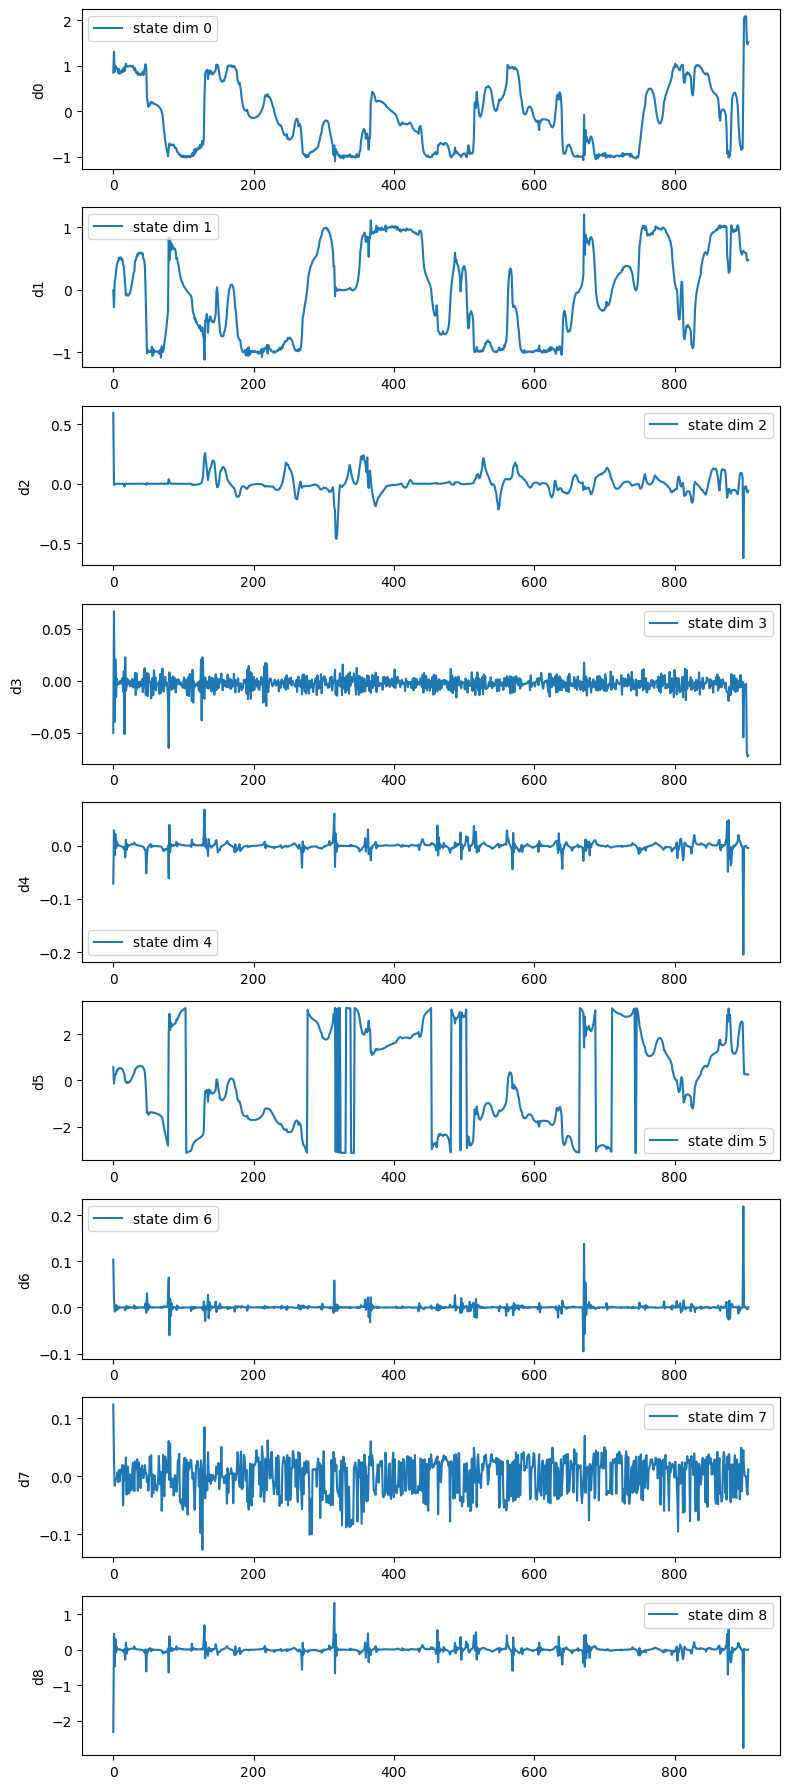

plot action dims


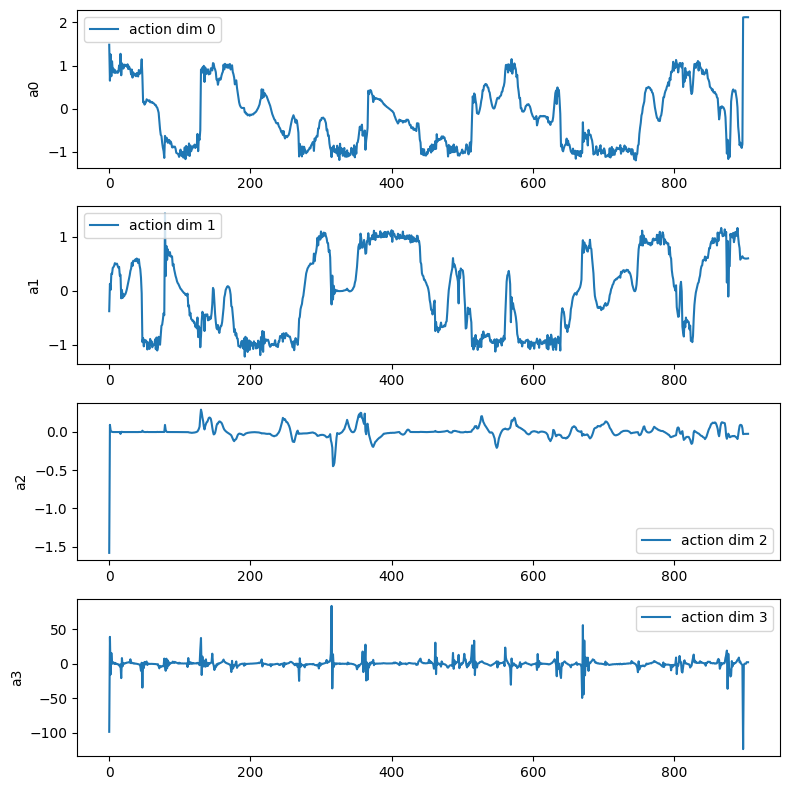

In [10]:
display_state_and_action_data_across_time(1)

### Understanding the Action Output

Each control signal in the action output has shape (16, N), where N is the number of control dimensions.
- 16 represents the action horizon (predictions for timesteps t, t+1, t+2, ..., t+15)



In [11]:
predicted_action = policy.get_action(step_data)
for key, value in predicted_action.items():
    print(key, value.shape)
    print(value)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


action.drone_action (16, 4)
[[-9.81848896e-01  3.53816867e-01  3.08330059e-02 -1.31246338e+01]
 [-9.88847136e-01  2.61046171e-01  4.46052551e-02 -1.43195801e+01]
 [-1.05882978e+00  1.17121577e-01  2.85376310e-02 -1.35229492e+01]
 [-1.12181413e+00  4.77602482e-02  1.70608759e-02 -1.39212646e+01]
 [-1.14980721e+00 -6.66857958e-02  2.16516256e-02 -1.23280029e+01]
 [-1.13581061e+00 -8.92281532e-02  1.93562508e-02 -9.93807983e+00]
 [-1.12181413e+00 -1.44717216e-01 -1.27788782e-02 -8.34481812e+00]
 [-1.17080200e+00 -1.36047006e-01 -3.57326269e-02 -9.93807983e+00]
 [-1.15680540e+00 -1.20440722e-01 -4.49140072e-02 -1.15313416e+01]
 [-1.10081935e+00 -8.57601166e-02 -5.63908815e-02 -1.75061035e+01]
 [-1.15680540e+00 -8.40260983e-02 -8.39352608e-02 -9.93807983e+00]
 [-1.12181413e+00 -5.10795116e-02 -9.54121351e-02 -1.27263184e+01]
 [-1.11481583e+00 -1.01366401e-01 -1.04593515e-01 -1.23280029e+01]
 [-1.08682275e+00 -1.34312987e-01 -8.62306356e-02 -8.34481812e+00]
 [-1.09382105e+00 -1.62057519e-01 

For reminder (can see in `meta/info.json` the actions is 4 dim : v1, v2, v3 and yaw angular speed)